In [1]:
%cd /content/drive/MyDrive/Colab/instate_v2/

/content/drive/MyDrive/Colab/instate_v2


In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from fastprogress import master_bar, progress_bar

In [3]:
# Load the data
df = pd.read_csv('data/final/lastname_langs_india.csv')

In [4]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaalapati,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aaarasavilly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aaavala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aabaaka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(731660, 38)

In [6]:
langs = df.columns.to_list()
# remove first element in columns
langs.pop(0)

'last_name'

In [10]:
df[langs].head().idxmax(axis=1)

0    bengali
1     telugu
2     telugu
3     telugu
4     telugu
dtype: object

In [11]:
df[langs].head().apply(lambda x: x.nlargest(2).idxmin(), axis=1)

0    hindi
1     urdu
2     urdu
3     urdu
4     urdu
dtype: object

In [12]:
df[langs].head().apply(lambda x: x.nlargest(3).idxmin(), axis=1)

0       urdu
1    chenchu
2    chenchu
3    chenchu
4    chenchu
dtype: object

In [13]:
# in each row, take the top 3 values and assign to first_lang, second_lang and third_lang
df['first_lang'] = df[langs].idxmax(axis=1)
df['second_lang'] = df[langs].apply(lambda x: x.nlargest(2).idxmin(), axis=1)
df['third_lang'] = df[langs].apply(lambda x: x.nlargest(3).idxmin(), axis=1)

In [14]:
# drop langs columns
df.drop(langs, axis=1, inplace=True)
# save df to csv
df.to_csv('data/final/lastname_langs_india_top3.csv', index=False)

In [15]:
# Splitting data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [16]:
train_df.to_csv('data/final/train_top3.csv', index=False)
val_df.to_csv('data/final/val_top3.csv', index=False)
test_df.to_csv('data/final/test_top3.csv', index=False)

In [7]:
# load train_df, val_df and test_df
train_df = pd.read_csv('data/final/train_top3.csv')
val_df = pd.read_csv('data/final/val_top3.csv')
test_df = pd.read_csv('data/final/test_top3.csv')

In [8]:
df.head()

,last_name,sindhi,nepali,kannada,marathi,mizo,adi,garo,tagin,assamese,...,telugu,malayalam,tamil,meitei,khasi,gondi,bodo,nishi,chakma,pahari and kumauni
0,aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aaalapati,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aaarasavilly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aaavala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aabaaka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Loading dataset

In [9]:
# Generate Character to Index Mapping
chars = set()
for name in df['last_name']:
    chars.update(name)
char2idx = {char: idx + 1 for idx, char in enumerate(chars)}
char2idx['<PAD>'] = 0
idx2char = {idx: char for char, idx in char2idx.items()}

In [10]:
# Build lang to index
lang2idx = {lang: idx for idx, lang in enumerate(langs)}
idx2lang = {idx: lang for lang, idx in lang2idx.items()}

In [11]:
class LangDataset(Dataset):
    def __init__(self, dataframe, char2idx, lang2idx):
        self.data = dataframe
        self.last_names = self.data['last_name'].values
        self.char2idx = char2idx
        self.lang2idx = lang2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        last_name = self.last_names[idx]
        # Convert last_name to tensor using the character mapping and padding to fixed length
        name_indices = [self.char2idx[char] for char in last_name]
        name_tensor = torch.tensor(name_indices, dtype=torch.long)
        # Get language indices based on first, second, and third language
        first_language_index = self.lang2idx[self.data.iloc[idx]['first_lang']]
        second_language_index = self.lang2idx[self.data.iloc[idx]['second_lang']]
        third_language_index = self.lang2idx[self.data.iloc[idx]['third_lang']]

        # Create a tensor with the language indices
        lang_tensor = torch.tensor([first_language_index, second_language_index, third_language_index], dtype=torch.float)

        return {'last_name': name_tensor, 'labels': lang_tensor}

In [12]:
# Creating datasets and dataloaders
train_dataset = LangDataset(train_df, char2idx, lang2idx)
val_dataset = LangDataset(val_df, char2idx, lang2idx)
test_dataset = LangDataset(test_df, char2idx, lang2idx)

In [13]:
# display first sample of train_dataset
first_element = train_dataset[0]

# Convert character indices back to the actual characters
last_name_characters = ''.join([idx2char[char.item()] for char in first_element['last_name']])

# Print first element details
print("First element in the train dataset:")
print("Last Name (Character Indices):", first_element['last_name'])
print("Last Name (Characters):", last_name_characters)

# Print labels
print("Labels:", first_element['labels'])
labels = first_element['labels']
print(f"Languages: {idx2lang[labels[0].item()]}, {idx2lang[labels[1].item()]}, {idx2lang[labels[2].item()]}")

First element in the train dataset:
Last Name (Character Indices): tensor([24,  2, 25, 16, 18, 22,  2, 25])
Last Name (Characters): bhinathi
Labels: tensor([27., 16., 15.])
Languages: telugu, urdu, chenchu


In [14]:
def collate_fn(samples):
    last_names = [sample['last_name'] for sample in samples]
    labels = torch.stack([sample['labels'] for sample in samples])
    lengths = torch.tensor([len(name) for name in last_names])
    last_names_padded = pad_sequence(last_names, batch_first=True, padding_value=0)
    return {'last_names': last_names_padded, 'labels': labels, 'lengths': lengths}

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [16]:
# Get the first batch
first_batch = next(iter(train_loader))

# Print the content of the first batch
print("First batch in the train DataLoader:")
print("Last Names (Character Indices):", first_batch['last_names'])
print("Labels:", first_batch['labels'])
print("Lengths:", first_batch['lengths'])

# Convert the character indices back to characters for the first few names in the batch
for i in range(min(3, len(first_batch['last_names']))):  # printing only the first three for brevity
    last_name_indices = first_batch['last_names'][i]
    last_name_characters = ''.join([idx2char[char.item()] for char in last_name_indices if char != 0])
    print(f"Last Name {i+1} (Characters):", last_name_characters)

First batch in the train DataLoader:
Last Names (Character Indices): tensor([[24, 18, 15, 25, 16,  5, 16, 25,  0,  0,  0,  0],
        [21,  4, 26, 26, 18, 16, 18,  0,  0,  0,  0,  0],
        [11, 18, 15, 15, 18, 18, 14, 25,  0,  0,  0,  0],
        [ 8,  4,  8, 25, 12, 18, 16, 25,  0,  0,  0,  0],
        [18, 18, 26,  3,  8,  4, 16, 26, 18, 14, 18,  0],
        [20, 25, 16, 15, 25, 26, 18, 20,  3,  0,  0,  0],
        [ 2, 25, 21, 21, 18, 26, 25,  0,  0,  0,  0,  0],
        [ 2, 18, 22, 18, 16,  3, 12, 18,  0,  0,  0,  0],
        [19, 18, 18, 16, 26,  6, 18, 14,  0,  0,  0,  0],
        [ 8,  4, 14, 18, 15, 18, 18,  0,  0,  0,  0,  0],
        [ 9,  2,  3, 26, 18, 20, 18, 21, 18,  0,  0,  0],
        [21, 18, 14,  2, 18,  3, 22, 12,  0,  0,  0,  0],
        [20, 18, 14,  5, 14,  9, 18, 12,  0,  0,  0,  0],
        [26, 18, 20, 18, 21, 18,  2, 25, 20,  2,  6, 18],
        [18, 21, 18, 12, 18, 16,  5,  0,  0,  0,  0,  0],
        [11, 25, 20,  2, 10, 18, 20,  2,  0,  0,  0,  0],
   

## Model

In [18]:
import torch
import torch.nn as nn

class LanguagePredictor(nn.Module):
    def __init__(self, num_chars, embedding_dim=64, lstm_hidden_dim=128, num_languages=37):
        super(LanguagePredictor, self).__init__()
        self.embedding = nn.Embedding(num_chars, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_dim, num_languages)
        self.fc2 = nn.Linear(lstm_hidden_dim, num_languages)
        self.fc3 = nn.Linear(lstm_hidden_dim, num_languages)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        out1 = self.fc1(h_n)
        out2 = self.fc2(h_n)
        out3 = self.fc3(h_n)
        return out1, out2, out3

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
# Initialize model, loss function, optimizer
vocab_size = len(char2idx)
embedding_dim = 50
hidden_dim = 128  # Number of features in the hidden state of LSTM
num_languages = len(langs)            # We predict first, second, and third languages
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = LanguagePredictor(vocab_size, embedding_dim, hidden_dim, num_languages)
model.to(device)
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs=100
early_stopper = EarlyStopper(patience=10)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

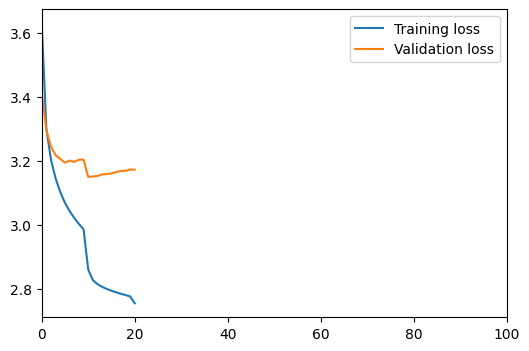

Validation loss decreased (inf --> 3.412694).  Saving model ...
Validation loss decreased (3.412694 --> 3.295809).  Saving model ...
Validation loss decreased (3.295809 --> 3.243790).  Saving model ...
Validation loss decreased (3.243790 --> 3.217533).  Saving model ...
Validation loss decreased (3.217533 --> 3.205790).  Saving model ...
Validation loss decreased (3.205790 --> 3.194003).  Saving model ...
Validation loss decreased (3.194003 --> 3.149574).  Saving model ...
Early stopping at epoch 20


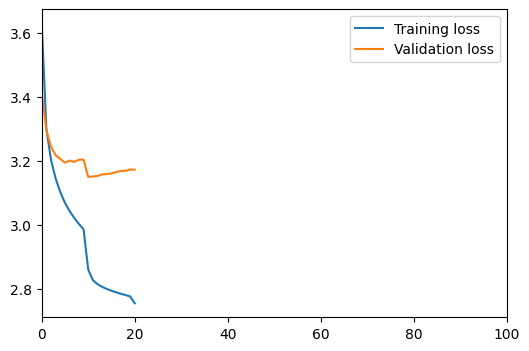

In [23]:
mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

# Training loop
for epoch in mb:
  x.append(epoch)
  total_loss = torch.Tensor([0.0]).to(device)

  # train
  model.train()
  for batch in progress_bar(train_loader, parent=mb):
    optimizer.zero_grad()
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    out1, out2, out3 = model(last_names, lengths)
    loss1 = criterion(out1, labels[:, 0].long())
    loss2 = criterion(out2, labels[:, 1].long())
    loss3 = criterion(out3, labels[:, 2].long())
    loss = loss1 + loss2 + loss3
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # decay lr
  scheduler.step()
  mean = total_loss / len(train_loader)
  training_losses.append(mean.cpu())

  # validation
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      last_names = batch['last_names'].to(device)
      labels = batch['labels'].to(device)
      lengths = batch['lengths']
      out1, out2, out3 = model(last_names, lengths)
      loss1 = criterion(out1, labels[:, 0].long())
      loss2 = criterion(out2, labels[:, 1].long())
      loss3 = criterion(out3, labels[:, 2].long())
      loss = loss1 + loss2 + loss3
      validation_loss += loss.item()

  val_mean = validation_loss / len(val_loader)
  validation_losses.append(val_mean.cpu())
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")

  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/instate_v2/state_lang_labels.pt')
      valid_mean_min = val_mean.item()

  # early stopping
  if early_stopper.early_stop(validation_losses[-1]):
    print(f"Early stopping at epoch {epoch}")
    break

In [89]:
!curl ntfy.sh/c -d "training done"

{"id":"JpEziOcvF1PK","time":1722166899,"expires":1722210099,"event":"message","topic":"c","message":"training done"}


In [24]:
# load the model

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/instate_v2/state_lang_labels.pt'))

<All keys matched successfully>

In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 100.0 MB/s eta 0:00:00


In [ ]:
len(test_df)

78309

In [ ]:
total_matches = 0
test_df_sample = test_df.sample(n=1000, random_state=42)

# for every lastname in test dataset find the nearest names in train dataset
for lastname in test_df_sample['last_name']:
  # use edit distance find top 3 nearest names
  distances = train_df['last_name'].apply(lambda x: distance(lastname, x))
  nearest_lang = train_df.loc[distances.nsmallest(3).index, langs].sum().idxmax()
  actual_lang = test_df_sample.loc[test_df['last_name'] == lastname, langs].values[0].argmax()
  if nearest_lang == langs[actual_lang]:
    total_matches += 1
  # sum the rest of the columns

print(f"Total records: {len(test_df_sample)}")
print(f"Total matches: {total_matches}")
print(f"Percent of matches: {total_matches / len(test_df_sample)}")

Total records: 1000
Total matches: 679
Percent of matches: 0.679


In [ ]:
# what if everything is predicted as hindi
total_hindi_matches = 0

for batch in test_loader:
  last_names = batch['last_names'].to(device)
  labels = batch['labels'].to(device)
  _, true = torch.max(labels, 1)
  hindi_tensor = torch.zeros(true.size()[0]) + langs.index('hindi')
  hindi_matches = (hindi_tensor.to(device) == true).sum().item()
  total_hindi_matches += hindi_matches

print(f"Total records: {len(test_df)}")
print(f"Total hindi matches: {total_hindi_matches}")
print(f"Percent of hindi matches: {total_hindi_matches / len(test_df)}")

Total records: 73166
Total hindi matches: 13142
Percent of hindi matches: 0.17961894869201542


In [26]:
len(langs)

37

In [31]:
langs[0]

'sindhi'

In [35]:
import torch.nn.functional as F

# verify on test dataset
model.eval()
first_lang_matches = 0
second_lang_matches = 0
third_lang_matches = 0

all_matches = 0

with torch.no_grad():
  for batch in test_loader:
    last_names = batch['last_names'].to(device)
    labels = batch['labels'].to(device)
    lengths = batch['lengths']
    out1, out2, out3 = model(last_names, lengths)
    pred_first_lang = torch.argmax(out1, dim=1)
    pred_second_lang = torch.argmax(out2, dim=1)
    pred_third_lang = torch.argmax(out3, dim=1)
    first_lang_matches += (pred_first_lang == labels[:, 0]).sum().item()
    second_lang_matches += (pred_second_lang == labels[:, 1]).sum().item()
    third_lang_matches += (pred_third_lang == labels[:, 2]).sum().item()
    # get all matches
    all_matches += ((pred_first_lang == labels[:, 0]) & (pred_second_lang == labels[:, 1]) & (pred_third_lang == labels[:, 2])).sum().item()

# find ratio between matches and actual
first_match_percent = first_lang_matches / len(test_df)
second_match_percent = second_lang_matches / len(test_df)
third_match_percent = third_lang_matches / len(test_df)
all_match_percent = all_matches / len(test_df)

print(f"First language accuracy: {first_match_percent}")
print(f"Second language accuracy: {second_match_percent}")
print(f"Third language accuracy: {third_match_percent}")
print(f"All language accuracy: {all_match_percent}")

First language accuracy: 0.7222617062570046
Second language accuracy: 0.6821064428833065
Third language accuracy: 0.6230626247163983
All language accuracy: 0.5051116638875981


In [79]:
# do inference based on last_name
def infer(lastname):
  with torch.no_grad():
    last_name_indices = [char2idx[char] for char in lastname]
    last_name_tensor = torch.tensor(last_name_indices, dtype=torch.long).unsqueeze(0).to(device)
    lengths = torch.tensor([len(lastname)], dtype=torch.long)
    out1, out2, out3 = model(last_name_tensor, lengths)
    pred_first_lang = torch.argmax(out1, dim=1)
    pred_second_lang = torch.argmax(out2, dim=1)
    pred_third_lang = torch.argmax(out3, dim=1)
    # if second lang matches first, go to the next argmax
    if pred_second_lang == pred_first_lang:
      pred_second_lang = torch.topk(out2, k=2, dim=1)[1][0][1]
    if pred_third_lang == pred_first_lang or pred_third_lang == pred_second_lang:
      pred_third_lang = torch.topk(out3, k=3, dim=1)[1][0][1]
    return idx2lang[pred_first_lang.item()], idx2lang[pred_second_lang.item()], idx2lang[pred_third_lang.item()]

In [80]:
infer("bachchan")

('hindi', 'bengali', 'urdu')

In [81]:
infer("chintalapati")

('telugu', 'urdu', 'chenchu')

In [82]:
infer("menon")

('malayalam', 'tamil', 'kannada')

In [83]:
infer("desai")

('hindi', 'urdu', 'kannada')

In [84]:
infer("chakraborty")

('bengali', 'punjabi', 'urdu')

In [85]:
infer("singh")

('hindi', 'punjabi', 'urdu')

In [86]:
infer("shetty")

('telugu', 'urdu', 'kannada')

In [87]:
infer("debasish")

('bengali', 'hindi', 'urdu')